<a href="https://colab.research.google.com/github/RanaHassan-harsan/Zeham-Management-Technologies-Bootcamp/blob/main/Week5/WeeklyTask/Time_Series_Forecasting_Practical_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [175]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [60]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
traffic-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  traffic-dataset.zip
replace Traffic Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [176]:
df = pd.read_csv('/content/Traffic Data.csv', parse_dates=['date_time'])

In [157]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00
...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00


In [158]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       19980 non-null  float64       
 1   temp                 20000 non-null  float64       
 2   rain_1h              20000 non-null  float64       
 3   snow_1h              20000 non-null  float64       
 4   clouds_all           20000 non-null  int64         
 5   weather_main         20000 non-null  object        
 6   weather_description  20000 non-null  object        
 7   date_time            20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [160]:
df['date_time'] = pd.to_datetime(df['date_time'], dayfirst=True)

In [252]:
df['traffic_volume'].unique()

array([1209., 1248., 4602., ..., 6742., 1783., 1132.])

In [15]:
#df['date_time'] = df.set_index('date_time', inplace=True)

In [161]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       19980 non-null  float64       
 1   temp                 20000 non-null  float64       
 2   rain_1h              20000 non-null  float64       
 3   snow_1h              20000 non-null  float64       
 4   clouds_all           20000 non-null  int64         
 5   weather_main         20000 non-null  object        
 6   weather_description  20000 non-null  object        
 7   date_time            20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.2+ MB


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

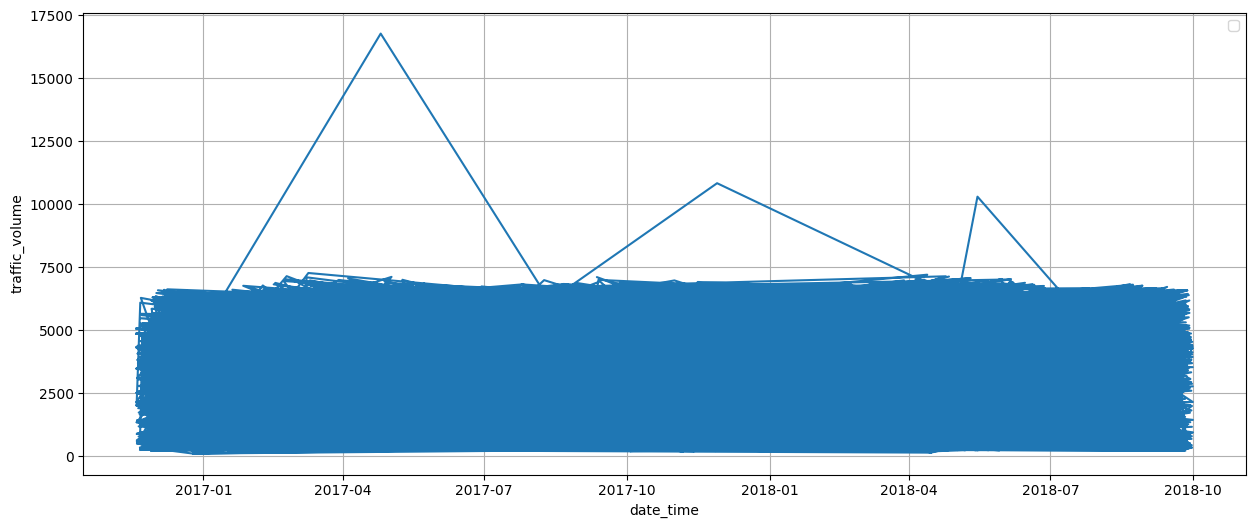

In [163]:
# Plot the time series data
plt.figure(figsize=(15, 6))
plt.plot(df['date_time'], df['traffic_volume'])
plt.xlabel('date_time')
plt.ylabel('traffic_volume')
plt.legend()
plt.grid(True)
plt.show()

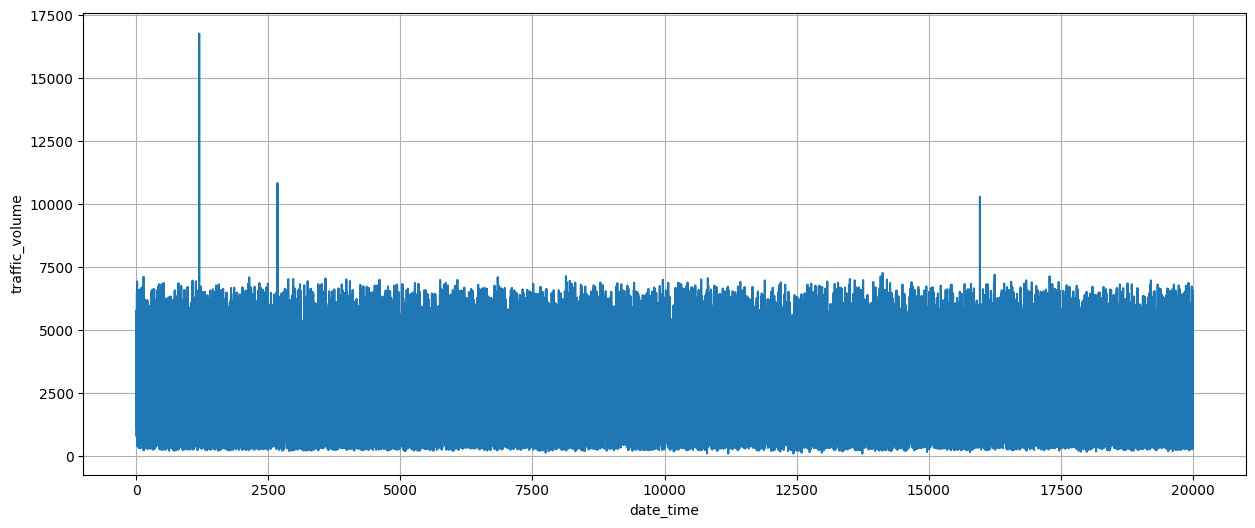

In [68]:
# plot time series data
plt.figure(figsize=(15, 6))
plt.plot(df['traffic_volume'])
plt.xlabel('date_time')
plt.ylabel('traffic_volume')
plt.grid(True)
plt.show()

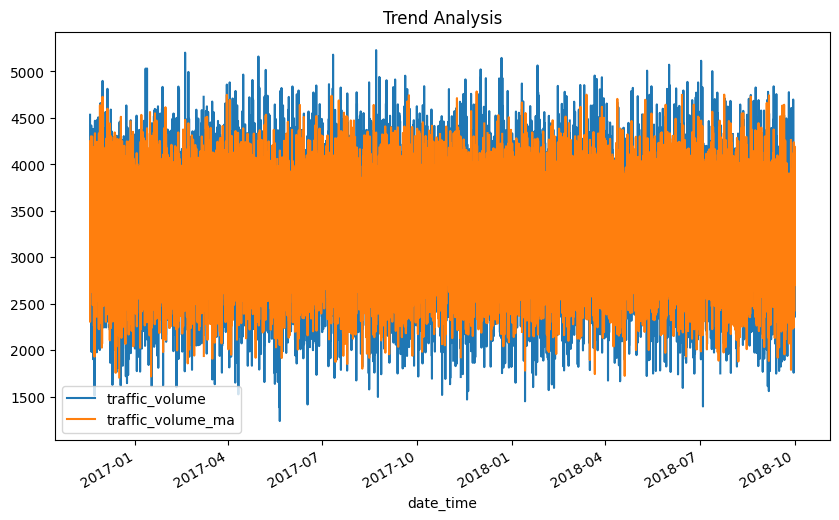

In [39]:
df['traffic_volume_ma'] = df['traffic_volume'].rolling(window=12).mean()
df[['traffic_volume', 'traffic_volume_ma']].plot(figsize=(10, 6))
plt.title('Trend Analysis')
plt.show()

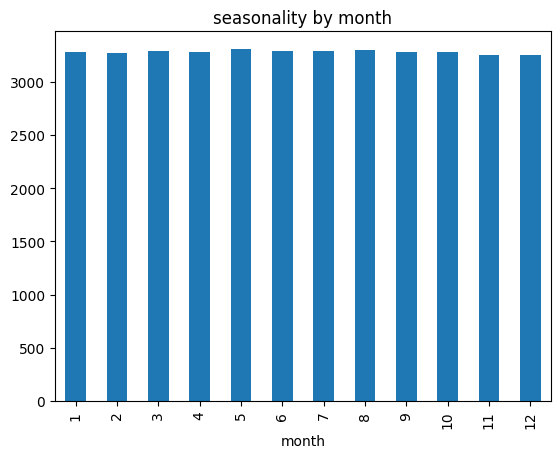

In [41]:
df['month'] = df.index.month  # استخراج الشهر من التاريخ
df.groupby('month')['traffic_volume'].mean().plot(kind='bar')
plt.title('seasonality by month')
plt.show()

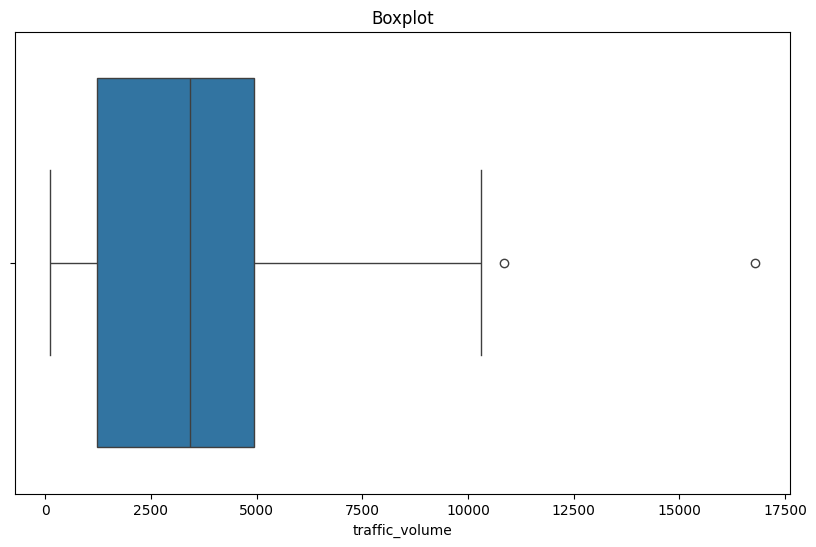

In [253]:
# boxplot to identify outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['traffic_volume'])
plt.title('Boxplot')
plt.show()

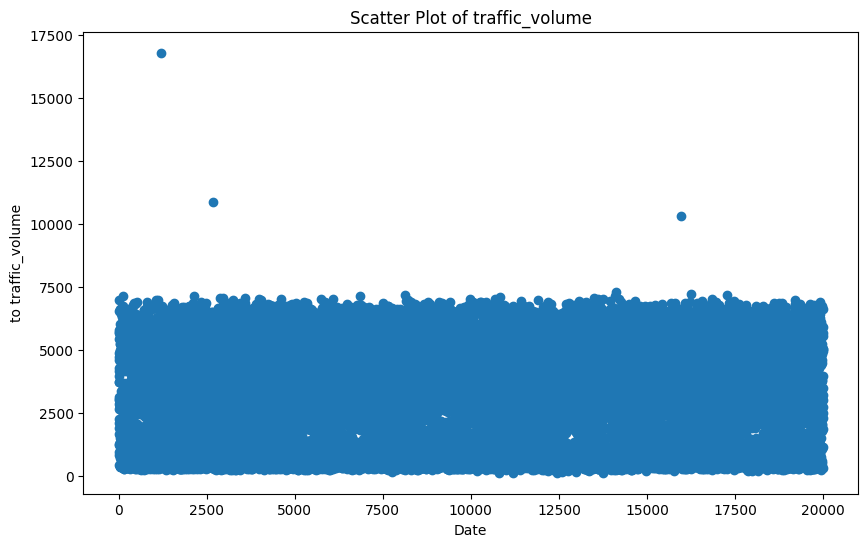

In [254]:
# Scatter plot to visualize anomalies over time
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['traffic_volume'])
plt.title('Scatter Plot of traffic_volume')
plt.xlabel('Date')
plt.ylabel('to traffic_volume')
plt.show()

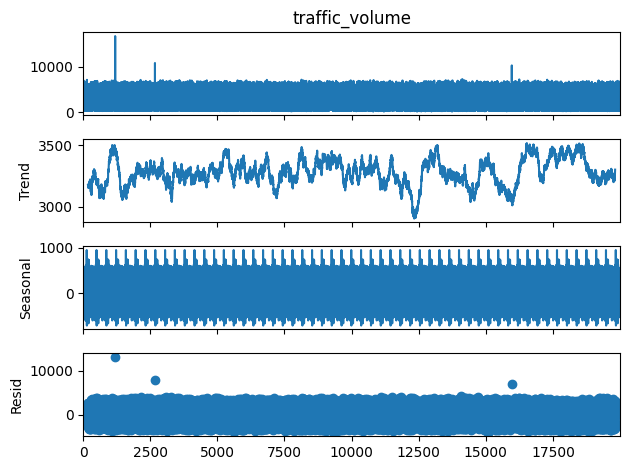

In [83]:
# Seasonal decomposition
decomposition = seasonal_decompose(df['traffic_volume'].interpolate(), model='additive', period=365)
decomposition.plot()
plt.show()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [48]:
df.isnull()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume_ma,Month,month
date_time,,,,,,,,,,,
2017-08-27 01:00:00,True,False,False,False,False,False,False,True,True,False,False
2018-09-06 23:00:00,True,False,False,False,False,False,False,True,True,False,False
2017-08-25 18:00:00,True,False,False,False,False,False,False,True,True,False,False
2017-11-09 22:00:00,True,False,False,False,False,False,False,True,True,False,False
2017-11-09 15:00:00,True,False,False,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2018-06-06 21:00:00,False,False,False,False,False,False,False,True,False,False,False
2017-10-25 15:00:00,False,False,False,False,False,False,False,True,False,False,False
2018-03-28 23:00:00,False,False,False,False,False,False,False,True,False,False,False


In [49]:
df.isnull().sum()

,0
traffic_volume,251
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,20000
traffic_volume_ma,482
Month,0


In [165]:
df = df.interpolate(method='linear')

<ipython-input-165-bdc865afced7>:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear')


In [51]:
df.isnull().sum()

,0
traffic_volume,11
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,20000
traffic_volume_ma,22
Month,0


In [52]:
#df = df.sort_values(by='date_time')

ValueError: 'date_time' is both an index level and a column label, which is ambiguous.

In [166]:
missing_val = df_sorted.isnull().sum()

In [167]:
missing_val

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [181]:
df2 = df_sorted.dropna(subset=['traffic_volume'])

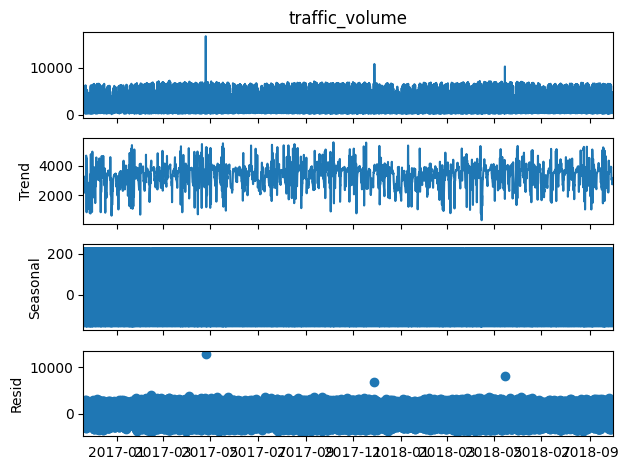

In [182]:
df_cleaned = seasonal_decompose(df2.set_index('date_time')['traffic_volume'], model='additive', period= 24)
df_cleaned.plot()
plt.show()

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [183]:
df2['prev_traffic_volume'] = df2['traffic_volume'].shift(1)

<ipython-input-183-6ade4c2fc6d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['prev_traffic_volume'] = df2['traffic_volume'].shift(1)


In [184]:
df2['day_of_week'] = df2['date_time'].dt.dayofweek
df2['month'] = df2['date_time'].dt.month
df2['day_of_year'] = df2['date_time'].dt.dayofyear

<ipython-input-184-34812988cc2b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['day_of_week'] = df2['date_time'].dt.dayofweek
<ipython-input-184-34812988cc2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['month'] = df2['date_time'].dt.month
<ipython-input-184-34812988cc2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [185]:
df2['diff_date_time'] = df2['date_time'].diff()

<ipython-input-185-e3835dc22067>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['diff_date_time'] = df2['date_time'].diff()


In [186]:
df2.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,prev_traffic_volume,day_of_week,month,day_of_year,diff_date_time
7745,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,2016-11-18 15:00:00,NaN,4,11,323,NaT
4628,4872.0,274.08,0.0,0.0,90,Fog,fog,2016-11-18 15:00:00,4872.0,4,11,323,0 days 00:00:00
14496,4872.0,274.08,0.0,0.0,90,Mist,mist,2016-11-18 15:00:00,4872.0,4,11,323,0 days 00:00:00
8867,5074.0,273.84,0.0,0.0,90,Fog,fog,2016-11-18 16:00:00,4872.0,4,11,323,0 days 01:00:00
3867,5074.0,273.84,0.0,0.0,90,Mist,mist,2016-11-18 16:00:00,5074.0,4,11,323,0 days 00:00:00


In [187]:
df2 = df2.dropna()

In [188]:
df2 = df2.sort_values(by='date_time')

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [189]:
train_size = int(len(df2) * 0.8)
train, test = df2[:train_size], df2[train_size:]

In [190]:
train_split = round(len(df2) * 0.8)
train_data = df2.iloc[:train_split]
test_data = df2.iloc[train_split:]

In [191]:
len(train_data), len(test_data)

(15983, 3996)

In [192]:
train_data.shape

(15983, 13)

In [193]:
test_data.shape

(3996, 13)

In [194]:
train_X = train.drop(['traffic_volume', 'date_time'], axis=1)
train_y = train['traffic_volume']

In [195]:
test_X = test.drop(['traffic_volume', 'date_time'], axis=1)
test_y = test['traffic_volume']

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [196]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [197]:
scaler.fit(train_data[['traffic_volume', 'prev_traffic_volume']])

MinMaxScaler()

In [198]:
# Transform both training and testing data
train_data_scaled = train_data.copy()
test_data_scaled = test_data.copy()

train_data_scaled[['traffic_volume', 'prev_traffic_volume']] = scaler.transform(train_data[['traffic_volume', 'prev_traffic_volume']])
test_data_scaled[['traffic_volume', 'prev_traffic_volume']] = scaler.transform(test_data[['traffic_volume', 'prev_traffic_volume']])

In [199]:
train_data_scaled.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,prev_traffic_volume,day_of_week,month,day_of_year,diff_date_time
4628,0.285517,274.08,0.0,0.0,90,Fog,fog,2016-11-18 15:00:00,0.285517,4,11,323,0 days 00:00:00
14496,0.285517,274.08,0.0,0.0,90,Mist,mist,2016-11-18 15:00:00,0.285517,4,11,323,0 days 00:00:00
8867,0.297636,273.84,0.0,0.0,90,Fog,fog,2016-11-18 16:00:00,0.285517,4,11,323,0 days 01:00:00
3867,0.297636,273.84,0.0,0.0,90,Mist,mist,2016-11-18 16:00:00,0.297636,4,11,323,0 days 00:00:00
18985,0.297636,273.84,0.0,0.0,90,Snow,heavy snow,2016-11-18 16:00:00,0.297636,4,11,323,0 days 00:00:00


In [200]:
test_data_scaled.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,prev_traffic_volume,day_of_week,month,day_of_year,diff_date_time
14852,0.101032,295.37,0.0,0.0,1,Clear,sky is clear,2018-05-18 23:00:00,0.156887,4,5,138,0 days 01:00:00
16858,0.078414,294.62,0.0,0.0,90,Rain,moderate rain,2018-05-19 00:00:00,0.101032,5,5,139,0 days 01:00:00
12618,0.044516,293.51,0.0,0.0,75,Rain,moderate rain,2018-05-19 01:00:00,0.078414,5,5,139,0 days 01:00:00
1120,0.031557,292.72,0.0,0.0,75,Clouds,broken clouds,2018-05-19 02:00:00,0.044516,5,5,139,0 days 01:00:00
1431,0.022858,292.28,0.0,0.0,75,Rain,light rain,2018-05-19 03:00:00,0.031557,5,5,139,0 days 01:00:00


In [201]:
train_data_scaled[:5], train_y[:5]

(       traffic_volume    temp  rain_1h  snow_1h  clouds_all weather_main  \
 4628         0.285517  274.08      0.0      0.0          90          Fog   
 14496        0.285517  274.08      0.0      0.0          90         Mist   
 8867         0.297636  273.84      0.0      0.0          90          Fog   
 3867         0.297636  273.84      0.0      0.0          90         Mist   
 18985        0.297636  273.84      0.0      0.0          90         Snow   
 
       weather_description           date_time  prev_traffic_volume  \
 4628                  fog 2016-11-18 15:00:00             0.285517   
 14496                mist 2016-11-18 15:00:00             0.285517   
 8867                  fog 2016-11-18 16:00:00             0.285517   
 3867                 mist 2016-11-18 16:00:00             0.297636   
 18985          heavy snow 2016-11-18 16:00:00             0.297636   
 
        day_of_week  month  day_of_year  diff_date_time  
 4628             4     11          323 0 days 00:

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [ ]:
# i choose ARIMA & LSTM model

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [121]:
model1 = ARIMA(train_y, order=(5, 1, 0))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [124]:
model1_fit = model1.fit()

In [125]:
model1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                15983
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -127293.992
Date:                Sun, 25 Aug 2024   AIC                         254599.984
Time:                        06:35:46   BIC                         254646.059
Sample:                             0   HQIC                        254615.223
                              - 15983                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4408      0.003    166.826      0.000       0.436       0.446
ar.L2          0.0090      0.004      2.077      0.038       0.001       0.018
ar.L3         -0.1037      0.008    -12.985      0.000      -0.119      -0.088
ar.L4          0.0068      0.009      0.726      0.468      -0.011       0.025
ar.L5         -0.0120      0.010     -1.251      0.211      -0.031       0.007
sigma2       4.85e+05   1710.438    283.567      0.000    4.82e+05    4.88e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1126528.91
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.32
Prob(H) (two-sided):                  0.30   Kurtosis:                        44.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [127]:
pred_model1 = model1_fit.forecast(steps= len(test_X))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [130]:
mae_arima = mean_absolute_error(test['traffic_volume'], pred_model1)
mse_arima = mean_squared_error(test['traffic_volume'], pred_model1)
rmse_arima = mse_arima ** 0.5

In [131]:
mae_arima

1760.011096647538

In [132]:
mse_arima

4007511.9094111375

In [133]:
rmse_arima

2001.8770964799855

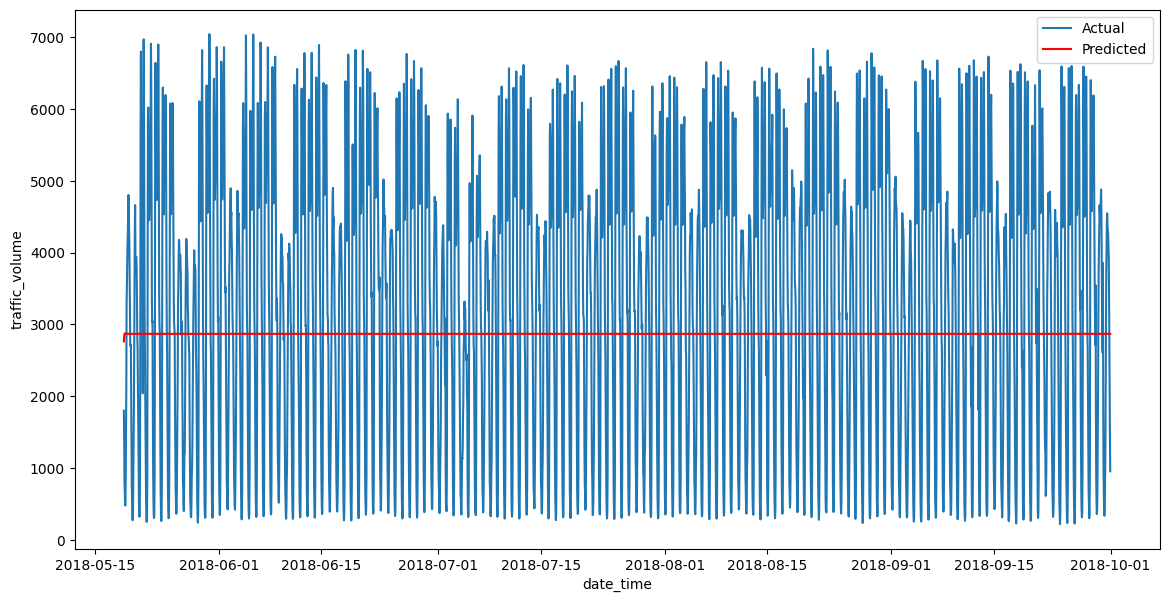

In [137]:
# Plot predicted vs actual
plt.figure(figsize=(14, 7))
plt.plot(test['date_time'], test['traffic_volume'], label='Actual')
plt.plot(test['date_time'], pred_model1, label='Predicted', color='red')
plt.xlabel('date_time')
plt.ylabel('traffic_volume')
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [214]:
# Prepare the data for LSTM
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0:dataset.shape[1]]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [227]:
train_X, train_y = create_dataset(train_data_scaled, 10)
X_test, Y_test = create_dataset(test_data_scaled, 10)

InvalidIndexError: (slice(0, 10, None), slice(0, 13, None))

In [237]:
X_train_lstm = train_data_scaled.reshape((train_data_scaled.shape[0], 1, train_data_scaled.shape[1]))
X_test_lstm = test_data_scaled.reshape((test_data_scaled.shape[0], 1, test_data_scaled.shape[1]))

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [232]:
model2 = Sequential()
model2.add(LSTM(64, return_sequences=True, input_shape=(10, 5)))
model2.add(LSTM(64))
model2.add(Dense(1))


In [234]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [235]:
model2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 10, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,009 (199.25 KB)

 Trainable params: 51,009 (199.25 KB)

 Non-trainable params: 0 (0.00 B)

In [239]:
model2.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y))

ValueError: could not convert string to float: 'Fog'

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [205]:
pred_model2 = model2.predict(X_test_lstm)

NameError: name 'X_test_lstm' is not defined

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [212]:
mse_lstm = mean_squared_error(test_y, pred_model2)

NameError: name 'pred_model2' is not defined

In [207]:
mse_lstm

NameError: name 'mse_lstm' is not defined

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here: